In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import copy
import numpy as np
import scipy
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch_geometric.utils as utils
from torch_geometric.datasets import Planetoid

In [7]:
class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim=None, sigma=False, bias=False):
        super(MLP, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim, bias=bias)
        if output_dim != None:
            self.linear_2 = nn.Linear(hidden_dim, output_dim, bias=bias)
        self.sigma = sigma
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
    def forward(self, x):
        x = self.linear_1(x)
        if self.sigma and self.output_dim != None:
            x = F.relu(x)
            x = self.linear_2(x)
        return (x)
    

    
class Node:
    
    def __init__(self, x, y, mlp, learning_rate, node_id):
        
        self.x = x
        self.y = y.view(1)
        self.mlp = mlp
        self.node_id = node_id
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.SGD(self.mlp.parameters(), lr=self.learning_rate)
        
    def receive_params(self, parameters):
        
        # parameters: a dict of parameters: {"linear_1.weight": tensor,......}
        with torch.no_grad():
            for name, param in self.mlp.named_parameters():
                param.copy_(parameters[name])
                
        
    def upload_params(self):
        
        # return a dict of parameters: {"linear_1,weight":" tensor,......,}
        return mlp.state_dict()
    
    # Use this funtion only at the beginning of each communication
    def upload_h(self): 
        
        self.optimizer.zero_grad()
        h = self.mlp(self.x)
        return h
    
    def receive_and_update(self, Abar_v, h_u, h_v, E):
        
        
        # h_u is the aggregated information of the neighboors of node v, it is constant
        # Abar_v is the corresponding constant for h_v and it is constant
        # E is the number of local updates
        
        # Note that: this function can only deal with node has only one set of data
        
        Z_v = Abar_v*h_v + h_u
        yhat_v = F.log_softmax(Z_v, dim=0)
        loss = F.nll_loss(yhat_v.view(1,-1), self.y)
        loss.backward()
        self.optimizer.step()
        
        for e in range(E-1):
            self.optimizer.zero_grad()
            h_v = self.mlp(self.x)
            Z_v = (Abar_v*h_v + h_u)
            yhat_v = F.log_softmax(Z_v, dim=0)
            loss = F.nll_loss(yhat_v.view(1,-1), self.y)
            loss.backward()
            self.optimizer.step()
        
        
        
        
class Central_Server:
    
    def __init__(self, edge_index, node_list, A, K, alpha=0.95):
        
        self.edge_index = edge_index
        self.node_list = node_list
        self.A = A
        self.alpha = alpha
        self.K = K
        self.Abar = None
        self.central_params = None
        self.num_nodes = len(node_list)
        
    def testing_mlp(self, input_dim, hidden_dim, output_dim=None, sigma=False):
        self.mlp = MLP(input_dim, hidden_dim, output_dim, sigma)
        
        
        
    def receive_h(self):
        
        H = []
        for v in self.node_list:
            h_v = v.upload_h()
            H.append(h_v)
        return H
    
    def compute_Abar(self):
        
        N = self.num_nodes
        A_bar = torch.zeros((N,N))
        A_i = torch.diag(torch.ones(N))
        alpha_i = 1
        for i in range(0, self.K+1):
            A_bar = A_bar + alpha_i*A_i
            alpha_i = alpha_i * self.alpha
            A_i = torch.matmul(A_i, self.A)
        A_bar = (1-self.alpha)*A_bar
        self.Abar = A_bar
    
    def init_params(self):
        
        
        params = copy.deepcopy(self.node_list[0].mlp.state_dict())
        self.cparam_names = list(params.keys())
        
        with torch.no_grad():
            for param_name in params.keys():
                nn.init.normal_(params[param_name])
        self.central_params = params
        
        
            
    def one_communication(self, E):
        
        # Calculate the A_bar matrix, if it is not calculated already.
        if (self.Abar == None):
            self.compute_Abar()
            
        # If this is the first time, initilalize the central parameters.
        if (self.central_params == None):
            self.init_params()
            
        # Broadcast the current central parameters to all nodes:
        for v in self.node_list:
            v.receive_params(self.central_params)
            
        # forward through the MLP layers for each node
        H = self.receive_h()
        
        # Power iteration
        H_copy = torch.stack(H).clone().detach()
        Z_K = torch.matmul(self.Abar, H_copy)
        
        # Shape of H
        num_nodes, num_classes = H_copy.shape
        
        # Calculate the needed information for each node to get the yhat
        for i in range(num_nodes):
            with torch.no_grad():
                h_u = Z_K[i,:] - H_copy[i,:]*self.Abar[i,i]
            # Local update
            self.node_list[i].receive_and_update(self.Abar[i,i], h_u, H[i], E)
            
        # Collect the updated local parameters and aggregate
        with torch.no_grad():
            for pname in self.cparam_names:
                p = self.node_list[0].mlp.state_dict()[pname]
                for i in range(1, self.num_nodes):
                    p = p + self.node_list[i].mlp.state_dict()[pname]
                p = p/self.num_nodes
                self.central_params[pname] = p
                
            
            
    def training(self, T, E, data=None):
        
        accuracy = []
        for t in range(T):
            self.one_communication(E)
            if (t % 10 == 0):
                print ("Communication:", t)
            if (data != None):
                accuracy.append(self.training_accuracy(data, self.central_params))
                
        if (data != None):
            plt.plot(np.arange(T)+1, accuracy)
            return accuracy
                
            
    def training_accuracy(self, graph_data, params):
        
        X = graph_data.x
        Y = graph_data.y
        self.mlp.load_state_dict(params)
        with torch.no_grad():
                H = self.mlp(X)
                Z_K = torch.matmul(self.Abar, H)
                preds = torch.max(Z_K, dim=1)[1]
                counts = (preds == Y).sum()
        return counts.item()/self.num_nodes
    
    def one_communication2(self, E, num_training=500):
    
        # Calculate the A_bar matrix, if it is not calculated already.
        if (self.Abar == None):
            self.compute_Abar()
            
        # If this is the first time, initilalize the central parameters.
        if (self.central_params == None):
            self.init_params()
            
        # Broadcast the current central parameters to all nodes:
        for v in self.node_list:
            v.receive_params(self.central_params)
            
        # forward through the MLP layers for each node
        H = self.receive_h()
        
        # Power iteration
        H_copy = torch.stack(H).clone().detach()
        Z_K = torch.matmul(self.Abar, H_copy)
        
        # Shape of H
        num_nodes, num_classes = H_copy.shape
        
        # Calculate the needed information for each node to get the yhat
        for i in range(num_training):
            with torch.no_grad():
                h_u = Z_K[i,:] - H_copy[i,:]*self.Abar[i,i]
            # Local update
            self.node_list[i].receive_and_update(self.Abar[i,i], h_u, H[i], E)
            
        # Collect the updated local parameters and aggregate
        with torch.no_grad():
            for pname in self.cparam_names:
                p = self.node_list[0].mlp.state_dict()[pname]
                for i in range(1, num_training):
                    p = p + self.node_list[i].mlp.state_dict()[pname]
                p = p/num_training
                self.central_params[pname] = p
                
    def testing_accuracy(self, graph_data, params, num_training=500):

        X = graph_data.x
        Y = graph_data.y
        self.mlp.load_state_dict(params)
        with torch.no_grad():
                H = self.mlp(X)
                Z_K = torch.matmul(self.Abar, H)
                preds = torch.max(Z_K, dim=1)[1][num_training:]
                counts = (preds == Y[num_training:]).sum()
        return counts.item()/(self.num_nodes - num_training)
    
    def training_and_testing(self, T, E, data=None):
        
        accuracy = []
        for t in range(T):
            self.one_communication2(E)
            if (t % 10 == 0):
                print ("Communication:", t)
            if (data != None):
                accuracy.append(self.testing_accuracy(data, self.central_params))
                
        if (data != None):
            plt.plot(np.arange(T)+1, accuracy)
            return accuracy

In [3]:
def init_network(data, A, num_classes, hidden_dim, learning_rate, K,
                       output_dim=None, sigma=False):
    
    num_nodes, input_dim = data.x.shape
    node_list = []
    
    for v in range(num_nodes):
        
        if (output_dim != None and sigma == True):
            mlp = MLP(input_dim, hidden_dim, output_dim, sigma)
            
        else:
            mlp = MLP(input_dim, hidden_dim)
            
        node_v = Node(data.x[v,:], data.y[v], mlp, learning_rate, v)
        node_list.append(node_v)
    
    network = Central_Server(data.edge_index, node_list, A, K)
    
    network.testing_mlp(input_dim, hidden_dim, output_dim, sigma)
    
    return network

In [5]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
data.edge_index = utils.remove_self_loops(data.edge_index)[0]
data.edge_index = utils.add_remaining_self_loops(data.edge_index)[0]
G = utils.to_networkx(data, to_undirected=True)
A = torch.tensor(nx.linalg.graphmatrix.adjacency_matrix(G).todense()).type(torch.FloatTensor)
D = nx.linalg.graphmatrix.adjacency_matrix(G).todense() + nx.linalg.laplacianmatrix.laplacian_matrix(G).todense()
Dhalf = scipy.linalg.sqrtm(D)
Dnhalf = torch.tensor(scipy.linalg.inv(Dhalf)).type(torch.FloatTensor)
A = torch.matmul(torch.matmul(Dnhalf, A), Dnhalf)

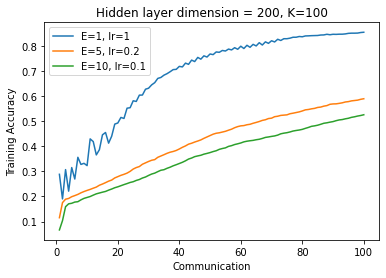

In [12]:
plt.plot(np.arange(1,101), accuracy1, label="E=1, lr=1")
plt.plot(np.arange(1,101), accuracy2, label="E=5, lr=0.2")
plt.plot(np.arange(1,101), accuracy3, label="E=10, lr=0.1")
plt.title("Hidden layer dimension = 200, K=100")
plt.xlabel("Communication")
plt.ylabel("Training Accuracy")
plt.legend(loc="best")
plt.savefig("200, 100, worse, training")

In [6]:
server1 = init_network(data, A, 7, 200, 0.1, 100, 7, True)
accuracy1 = server1.training_and_testing(10, 10, data)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

Communication: 0
Communication: 10
Communication: 20
Communication: 30
Communication: 40
Communication: 50
Communication: 60
Communication: 70
Communication: 80
Communication: 90


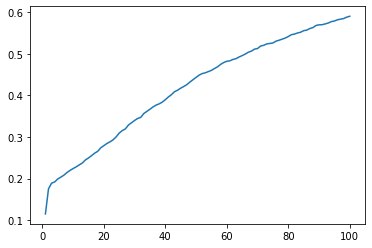

In [10]:
server2 = init_network(data, A, 7, 200, 0.2, 100, 7, True)
accuracy2 = server2.training(100, 5, data)

Communication: 0
Communication: 10
Communication: 20
Communication: 30
Communication: 40
Communication: 50
Communication: 60
Communication: 70
Communication: 80
Communication: 90


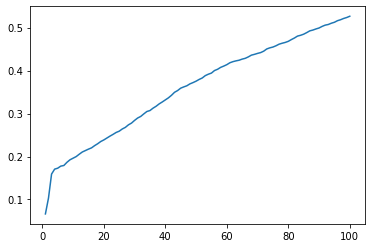

In [11]:
server3 = init_network(data, A, 7, 200, 0.1, 100, 7, True)
accuracy3 = server3.training(100, 10, data)